In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
fitter = fitting.LinearLSQFitter()
from scipy.ndimage import median_filter

In [2]:
fname='../../Type1/OGLEJ050650.94-700052.7/ADP.2020-11-16T16:11:14.683.fits'
harps='../../Type1/OGLEJ050650.94-700052.7/HARPS2005/ADP.2014-10-02T10:01:36.517.fits'
mucent='../../Mu_Centauri/ADP.2016-09-21T11:56:32.916.fits'

In [3]:
fits.getheader(mucent)

SIMPLE  =                    T / Written by IDL:  Tue Sep 20 19:10:22 2016      
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T / File contains extensions                       
DATASUM = '         0'         / data unit checksum updated 2016-09-20T19:10:24 
ORIGIN  = 'ESO-LASILLA'        / Origin                                         
FILENAME= 'f02331.bdf'         / Original file base-name                        
OBJECT  = 'mu-Cen  '           / Object                                         
RA      =           207.374222 / [deg] Right ascension                          
DEC     =            -42.47252 / [deg] Declination                              
EQUINOX =               2000.0 / Equinox                                        
DATE-OBS= '2006-06-04T23:00:46.273' / Start of observation                      
MJD-OBS =       53890.958868

In [4]:
fits.info(fname)

Filename: ../../Type1/OGLEJ050650.94-700052.7/ADP.2020-11-16T16:11:14.683.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1011   ()      
  1  SPECTRUM      1 BinTableHDU     71   1R x 6C   [131644D, 131644E, 131644E, 131644E, 131644E, 131644E]   


In [5]:
#plt.figure(figsize=(20,20))
#plt.imshow(fits.getdata(fname3).T[600:800],norm='log',vmin=200,aspect=10)
xd = fits.getdata(fname)
cent=fits.getdata(mucent)
harps=fits.getdata(harps)

In [30]:
#UVES
xd_new=xd['FLUX'][0][4145:-1719].tolist()
xd_filt=median_filter(xd_new,200)
lam = xd['WAVE'][0][4145:-1719]

mask_alpha=np.abs(6562.8-lam)>40
mask_beta=np.abs(4861.33333333333-lam)>40
mask_gamma=np.abs(4367.23-lam)>50 #H_gamma está corrido
mask=mask_alpha&mask_beta&mask_gamma

#HARPS
xdH_new=harps['FLUX'][0][4145:-1719].tolist()
xdH_filt=median_filter(xdH_new,400)
lamH = harps['WAVE'][0][4145:-1719]

mask_alphaH=np.abs(6562.8-lamH)>40
mask_betaH=np.abs(4861.33333333333-lamH)>40
mask_gammaH=np.abs(4367.23-lamH)>50 #H_gamma está corrido
maskH=mask_alphaH&mask_betaH&mask_gammaH


#MuCen
cent_new=cent['FLUX'][0][4145:-1719].tolist()
cent_filt=median_filter(cent_new,300)
lamc = cent['WAVE'][0][4145:-1719]

mask_alphac=np.abs(6562.8-lamc)>40
mask_betac=np.abs(4861.33333333333-lamc)>40
mask_gammac=np.abs(4367.23-lamc)>50 #H_gamma está corrido
maskc=mask_alphac&mask_betac&mask_gammac

In [31]:
modelo = fitter(models.Chebyshev1D(25),lam[mask],xd_filt[mask])
modeloH = fitter(models.Chebyshev1D(25),lamH[maskH],xdH_filt[maskH])
modeloc = fitter(models.Chebyshev1D(25),lamc[maskc],cent_filt[maskc])

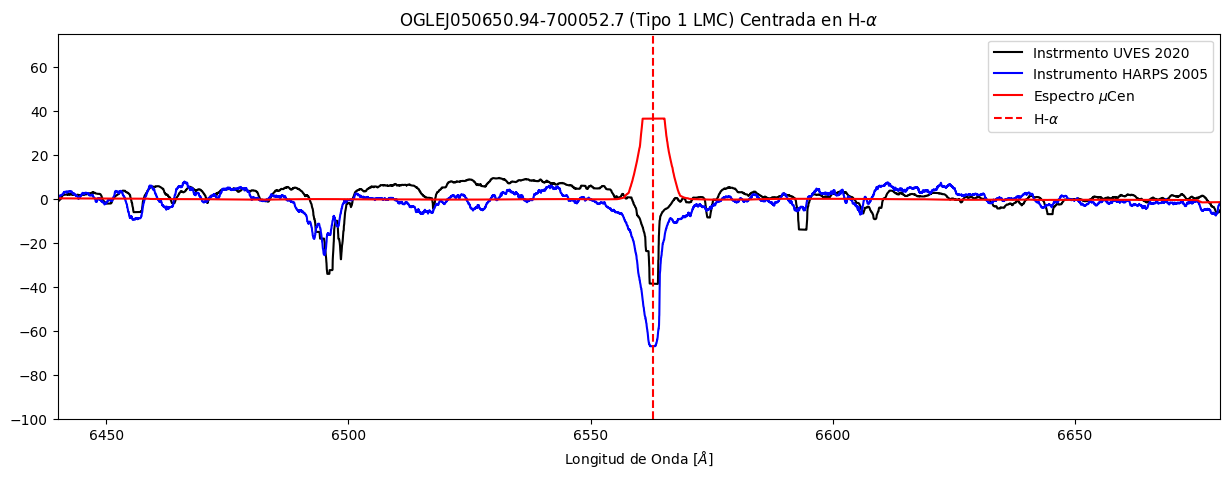

In [32]:
plt.figure(figsize=(15,5))
plt.plot(lam-5,xd_filt-modelo(lam), color='black', label='Instrmento UVES 2020')
plt.plot(lamH-5,xdH_filt-modeloH(lamH), color='blue', label='Instrumento HARPS 2005')
plt.plot(lamc,(cent_filt-modeloc(lamc))*10,color='red', label=r'Espectro $\mu$Cen')

plt.ylim(-100,75)
plt.xlim(6440,6680)#H-alpha
plt.axvline(x=6562.8, color='r', linestyle='--', label=r'H-$\alpha$ ')
plt.xlabel(r'Longitud de Onda [$\AA$]')
plt.legend()
plt.title(r'OGLEJ050650.94-700052.7 (Tipo 1 LMC) Centrada en H-$\alpha$')
plt.margins(x=0)
plt.savefig('harps_uves_type1LMC')